In [ ]:
!pip install python-doctr
!pip install tensorflow-addons

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
import math
from scipy.spatial import distance as dist
from scipy.stats import norm
import statistics
from doctr.models import ocr_predictor
from doctr.io import DocumentFile
import torch
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = ocr_predictor(pretrained=True)

In [ ]:
single_img_doc = DocumentFile.from_images("/content/0000989556.png")

In [ ]:
result = model(single_img_doc)

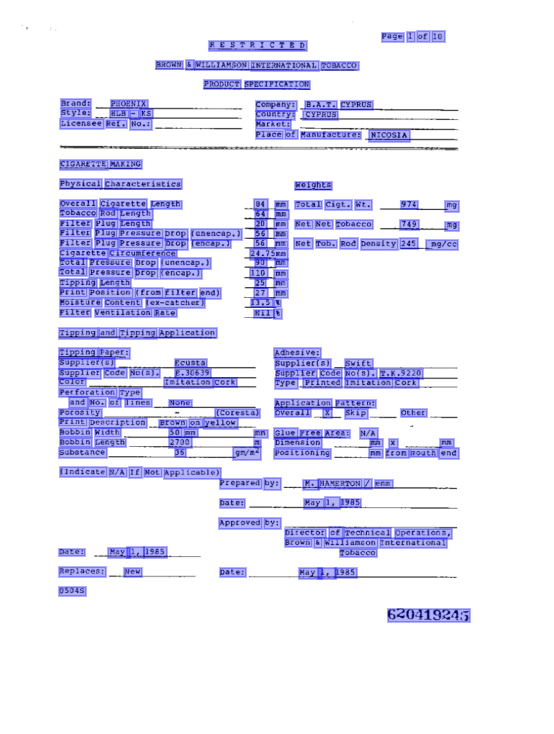

In [ ]:
result.show(single_img_doc)

In [ ]:
json_output = result.export()

In [ ]:
def rect_distance(a, b, vertical = False):
  acent = ((a[0]+a[2])/2, (a[1]+a[3])/2)
  bcent = ((b[0]+b[2])/2, (b[1]+b[3])/2)
  cendis = dist.euclidean(acent, bcent)
  if vertical:
    aside = (a[0], a[3])
    bside = (b[0], b[1])
  else:
    aside = (a[2], (a[3]+a[1])/2)
    bside = (b[0], (b[3]+b[1])/2)
  dis = dist.euclidean(aside, bside)
  return cendis, dis

def distance_bw_boxes(txt_file):
  cendisarr = []
  disarr = []
  for t in txt_file.split('\n'):
    h = t.split(' ')
    for j in b_json["form"]:
      if int(h[0]) == j["id"]:
        qbox = j["box"]
      if int(h[1]) == j["id"]:
        abox = j["box"]
    cendis, dis = rect_distance(qbox, abox)
    cendisarr.append(cendis)
    disarr.append(dis)
  return cendisarr, disarr

In [ ]:
# Structure of json
for i in json_output['pages']:
  print(i.keys())
  for j in i['blocks']:
    print(j.keys())
    for k in j['lines']:
      print(k.keys())
      for idx, l in enumerate(k['words']):
        print(l.keys())
        break
      # print('\n')
      break
    break
  break

dict_keys(['page_idx', 'dimensions', 'orientation', 'language', 'blocks'])
dict_keys(['geometry', 'lines', 'artefacts'])
dict_keys(['geometry', 'words'])
dict_keys(['value', 'confidence', 'geometry'])


In [ ]:
def plot_distribution(disarr):
  plt.figure()
  x_axis = np.arange(0, len(disarr), 1)
  plt.plot(x_axis, disarr)
  plt.show()

In [ ]:
def words_and_boxes():
  words_boxes = {}
  idx = 0
  for i in json_output['pages']:
    for j in i['blocks']:
      for k in j['lines']:
        for l in k['words']:
          box = l['geometry']
          box = [element for tupl in box for element in tupl]
          words_boxes[idx] = {'word' : l['value'],
                              'box' : box}
          idx += 1
  return words_boxes

def only_boxes():
  all_boxes = []
  for i in json_output['pages']:
    for j in i['blocks']:
      for k in j['lines']:
        for idx, l in enumerate(k['words']):
          box = k['words'][idx]['geometry']
          box = [element for tupl in box for element in tupl]
          all_boxes.append(box)
  return all_boxes

def only_words():
  all_wrds = []
  for i in json_output['pages']:
    for j in i['blocks']:
      for k in j['lines']:
        for idx, l in enumerate(k['words']):
          wrd = k['words'][idx]['value']
          all_wrds.append(wrd)
  return all_wrds

# def idx_words_and_boxes():
#   idx_wrds_boxes = {}
#   words_boxes = words_and_boxes()
#   for idx, i in enumerate(words_boxes):
#     idx_wrds_boxes[idx] = {i : words_boxes[i]}
#   return idx_wrds_boxes


def knn_boxes():
  tot_knn = []
  all_boxes = only_boxes()
  for i in json_output['pages']:
    for j in i['blocks']:
      for k in j['lines']:
        for idx, l in enumerate(k['words']):
          # print(all_boxes)
          box = k['words'][idx]['geometry']
          box = [element for tupl in box for element in tupl]
          box = torch.Tensor(box).unsqueeze(0)
          all_boxes = torch.Tensor(all_boxes)
          neighbours = torch.cdist(box, all_boxes, p = 2)
          knn = neighbours.topk(6, largest = False)
          tot_knn.append(knn)
  return tot_knn

In [ ]:
k_neighbours = knn_boxes()
print(k_neighbours[:5])

[torch.return_types.topk(
values=tensor([[0.0000, 0.0508, 0.0809, 0.1187, 0.1512, 0.1645]]),
indices=tensor([[  0,   1,   2,   3,  11, 101]])), torch.return_types.topk(
values=tensor([[0.0000, 0.0342, 0.0508, 0.0715, 0.1985, 0.1985]]),
indices=tensor([[  1,   2,   0,   3, 101,  11]])), torch.return_types.topk(
values=tensor([[0.0000, 0.0342, 0.0380, 0.0809, 0.2172, 0.2223]]),
indices=tensor([[  2,   1,   3,   0, 108, 101]])), torch.return_types.topk(
values=tensor([[0.0000, 0.0380, 0.0715, 0.1187, 0.2355, 0.2533]]),
indices=tensor([[  3,   2,   1,   0, 108, 101]])), torch.return_types.topk(
values=tensor([[0.0000, 0.0904, 0.1016, 0.1170, 0.1440, 0.1479]]),
indices=tensor([[ 4, 10,  6,  9,  5, 99]]))]


In [ ]:
def words_and_spacings():
  wrds_spacings = words_and_boxes()
  wrds = only_words()
  for idx, knn in enumerate(k_neighbours):
    for inds in knn.indices[0]:
      inds = np.array(inds)
      wrds_spacings[idx] = {'word' : wrds_spacings[idx]['word'],
                            'box' : knn.values.tolist()}
  
  return wrds_spacings

In [ ]:
wrds_spacing = words_and_spacings()
print(wrds_spacing)

{0: {'word': 'Page', 'box': [[0.0, 0.0508187972009182, 0.08091926574707031, 0.11870357394218445, 0.15123482048511505, 0.16452397406101227]]}, 1: {'word': '1', 'box': [[0.0, 0.03419363498687744, 0.0508187972009182, 0.07154278457164764, 0.1985258162021637, 0.19854502379894257]]}, 2: {'word': 'of', 'box': [[0.0, 0.03419363498687744, 0.03798564523458481, 0.08091926574707031, 0.21724729239940643, 0.2223326414823532]]}, 3: {'word': '10', 'box': [[0.0, 0.03798564523458481, 0.07154278457164764, 0.11870357394218445, 0.2354913204908371, 0.2533347010612488]]}, 4: {'word': 'RESTRICTED', 'box': [[0.0, 0.09038348495960236, 0.10160474479198456, 0.11695941537618637, 0.1440487653017044, 0.14791618287563324]]}, 5: {'word': 'PRODUCT', 'box': [[0.0, 0.04338839650154114, 0.10193273425102234, 0.1440487653017044, 0.14528152346611023, 0.14646483957767487]]}, 6: {'word': 'SPECIFICATION', 'box': [[0.0, 0.04153548926115036, 0.052815694361925125, 0.06941841542720795, 0.08800990134477615, 0.10160474479198456]]}, 7

In [ ]:
def k_neighbours_mean_std():
  wrds_spaces = words_and_spacings()
  idx = 0
  for i in json_output['pages']:
    for j in i['blocks']:
      block_dist = []
      for k in j['lines']:
        for l in k['words']:
          for b in wrds_spaces[idx]['box'][0]:
            block_dist.append(b)
          idx += 1
      print(f"Mean: {np.round(statistics.mean(block_dist), 3)} Std: {np.round(statistics.stdev(block_dist), 3)}")
      print('\n')

In [ ]:
k_neighbours_mean_std()

Mean: 0.101 Std: 0.084


Mean: 0.085 Std: 0.052


Mean: 0.092 Std: 0.052


Mean: 0.047 Std: 0.029


Mean: 0.04 Std: 0.023


Mean: 0.063 Std: 0.045


Mean: 0.064 Std: 0.037


Mean: 0.044 Std: 0.027


Mean: 0.069 Std: 0.044


Mean: 0.077 Std: 0.048


Mean: 0.032 Std: 0.019


Mean: 0.054 Std: 0.033


Mean: 0.057 Std: 0.033


Mean: 0.06 Std: 0.037


Mean: 0.055 Std: 0.037


Mean: 0.034 Std: 0.02


Mean: 0.077 Std: 0.058


Mean: 0.069 Std: 0.038


Mean: 0.056 Std: 0.029


Mean: 0.067 Std: 0.047


Mean: 0.09 Std: 0.061


Mean: 0.078 Std: 0.056


Mean: 0.052 Std: 0.033


Mean: 0.123 Std: 0.067


Mean: 0.058 Std: 0.031


Mean: 0.171 Std: 0.092




In [ ]:
def k_neighbours_blockwise_plot():
  wrds_spaces = words_and_spacings()
  idx = 0
  for i in json_output['pages']:
    for j in i['blocks']:
      block_dist = []
      for k in j['lines']:
        for l in k['words']:
          # print(wrds_spacing[l['value']])
          for b in wrds_spaces[idx]['box'][0]:
            block_dist.append(b)
          idx += 1
      plot_distribution(block_dist)
      print('\n')

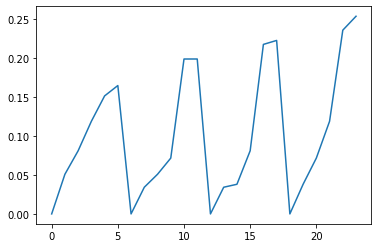

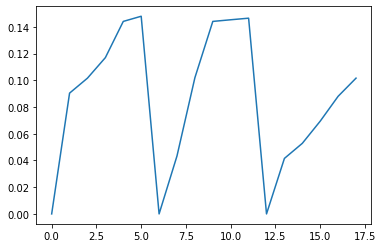

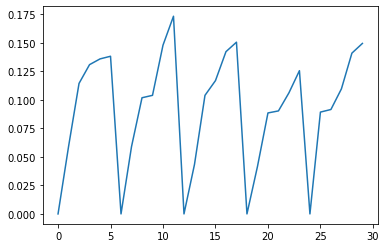

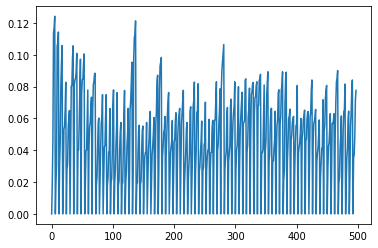

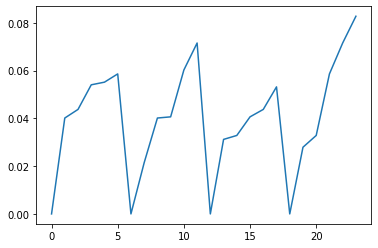

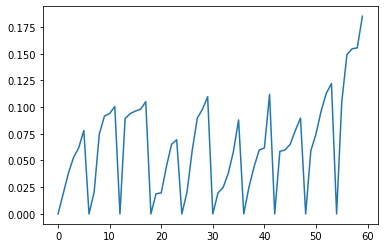

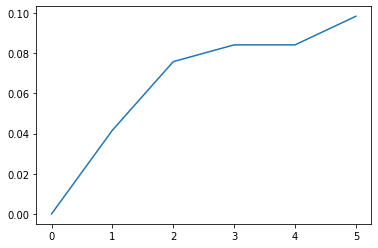

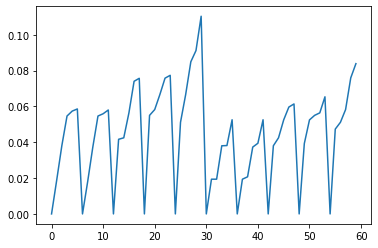

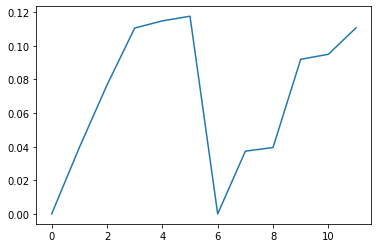

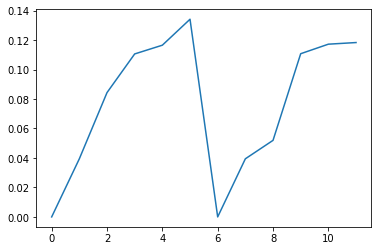

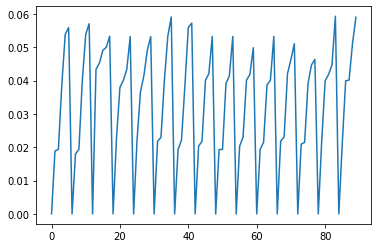

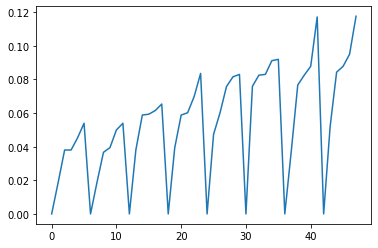

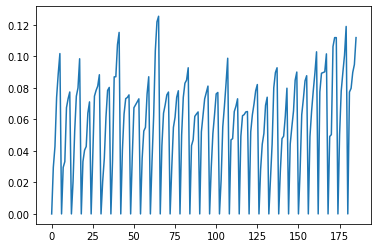

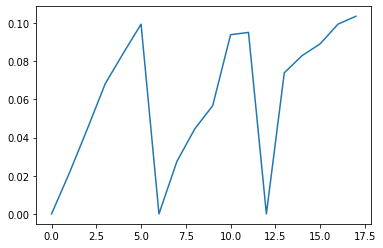

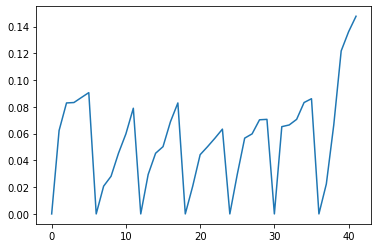

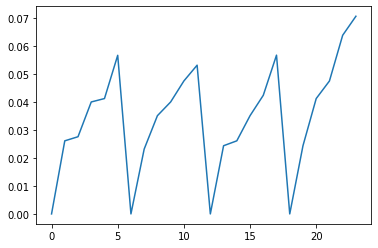

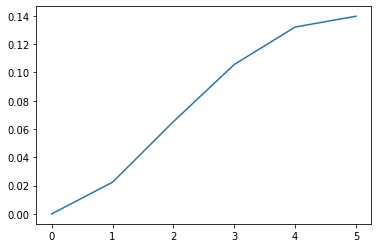

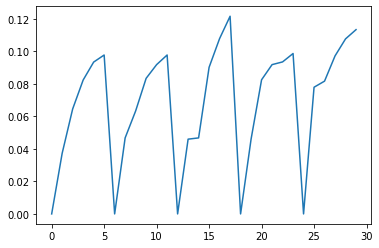

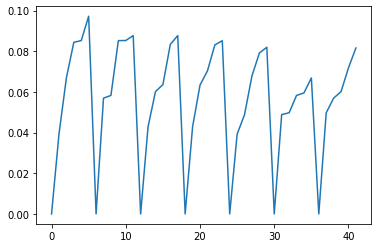

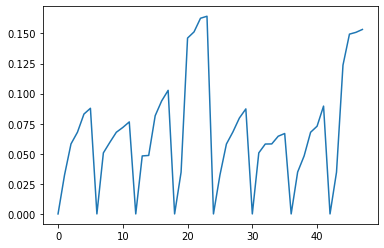

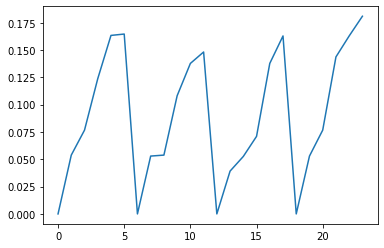

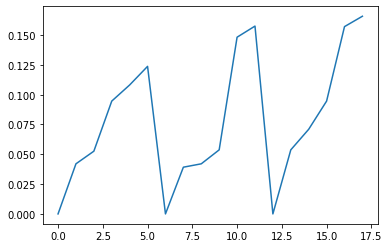

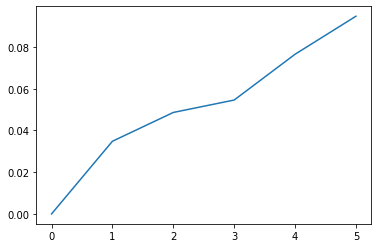

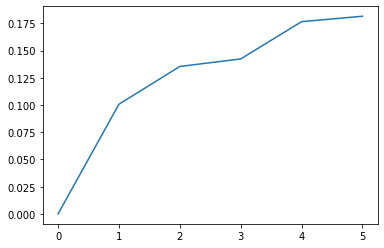

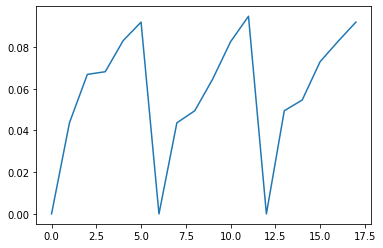

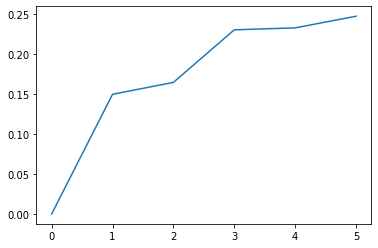

In [ ]:
k_neighbours_blockwise_plot()

In [ ]:
def k_neighbours_plot():
  wrds_spaces = words_and_spacings()
  idx = 0
  for i in json_output['pages']:
    for j in i['blocks']:
      for k in j['lines']:
        for l in k['words']:
          # print(wrds_spacing[l['value']])
          plot_distribution(wrds_spaces[idx]['box'][0])
          idx += 1
      print('\n')

In [ ]:
k_neighbours_plot()

In [ ]:
def wrd_hdist():
  tot_cenhdist_wrd = []
  tot_hdist_wrd = []
  for i in json_output['pages']:
    for j in i['blocks']:
      for k in j['lines']:
        for idx, l in enumerate(k['words']):
          if idx < len(k['words']) - 1:
            box1 = k['words'][idx]['geometry']
            box2 = k['words'][idx + 1]['geometry']
            box1 = [element for tupl in box1 for element in tupl]
            box2 = [element for tupl in box2 for element in tupl]
            dist_wrd = rect_distance(box1, box2)
            tot_cenhdist_wrd.append(dist_wrd[0])
            tot_hdist_wrd.append(dist_wrd[1])
  return tot_cenhdist_wrd, tot_hdist_wrd

def wrd_hdist_plot():
  tot_cenhdist_wrd, tot_hdist_wrd = wrd_hdist()
  plot_distribution(tot_hdist_wrd)

def wrd_hdist_blockwise():
  
    for i in json_output['pages']:
      for j in i['blocks']:
        block_dist = []
        for k in j['lines']:
          for idx, l in enumerate(k['words']):
            if idx < len(k['words']) - 1:
              box1 = k['words'][idx]['geometry']
              box2 = k['words'][idx + 1]['geometry']
              box1 = [element for tupl in box1 for element in tupl]
              box2 = [element for tupl in box2 for element in tupl]
              dist_wrd = rect_distance(box1, box2)
              print(f"{k['words'][idx]['value']} {k['words'][idx + 1]['value']} {dist_wrd}")
              block_dist.append(dist_wrd[1])
        try:
          plot_distribution(block_dist)
        except Exception as e:
          print(e)
          pass
              # print(f"{l['value']} : {l['geometry']}")
        print('\n')

In [ ]:
def get_vword_json():
  vword_json = {'words' : []}
  for i in json_output['pages']:
    for j in i['blocks']:
      for k in j['lines']:
        for idx, l in enumerate(k['words']):
          # print(f"{l['value']} {l['geometry']}")
          vword_json['words'].append({
              'value' : l['value'],
              'geometry' : l['geometry']
          })
          break
  return vword_json

In [ ]:
vword_json = get_vword_json()

In [ ]:
def word_to_word_vdist(word_json, printout = True):
  tot_vdist = []
  for idx, k in enumerate(word_json['words']):
    if idx < len(word_json['words']) - 1:
      box1 = word_json['words'][idx]['geometry']
      box2 = word_json['words'][idx + 1]['geometry']
      box1 = [element for tupl in box1 for element in tupl]
      box2 = [element for tupl in box2 for element in tupl]
      dist_wrd = rect_distance(box1, box2, vertical = True)
      if printout:
        print(f"{word_json['words'][idx]['value']} {word_json['words'][idx+1]['value']} {round(dist_wrd[0], 5)} {round(dist_wrd[1], 5)}")
      tot_vdist.append(dist_wrd[1])
  return tot_vdist


def word_to_word_vdist_plot(word_json):
  tot_vdist = word_to_word_vdist(word_json)
  plot_distribution(tot_vdist)

Page RESTRICTED 0.25027 0.32031
RESTRICTED PRODUCT 0.08465 0.04195
PRODUCT BROWN 0.10235 0.09797
BROWN Brand: 0.181 0.18073
Brand: Style: 0.01368 0.00218
Style: Licensee 0.01788 0.00276
Licensee CIGARETTE 0.05678 0.04298
CIGARETTE Physical 0.02787 0.01367
Physical Overall 0.02778 0.01468
Overall Tobacco 0.0127 0.00098
Tobacco Filter 0.01544 0.00293
Filter Filter 0.0127 0.00098
Filter Filter 0.01465 0.00309
Filter Cigarette 0.02072 0.00195
Cigarette Total 0.02278 0.00098
Total Total 0.01368 0.00218
Total Tipping 0.01896 0.00437
Tipping Print 0.01632 0.00138
Print Moisture 0.02037 0.00293
Moisture Filter 0.01709 0.00293
Filter Tipping 0.02979 0.01663
Tipping Tipping 0.02734 0.0127
Tipping Supplier(s) 0.02113 0.00098
Supplier(s) Supplier 0.01938 0.0
Supplier Color 0.01846 0.00195
Color Perforation 0.03232 0.00195
Perforation and 0.02295 0.01758
and Porosity 0.01576 0.01761
Porosity Print 0.01838 0.00098
Print Bobbin 0.0156 0.00309
Bobbin Bobbin 0.01367 0.00195
Bobbin Substance 0.02004 0.0

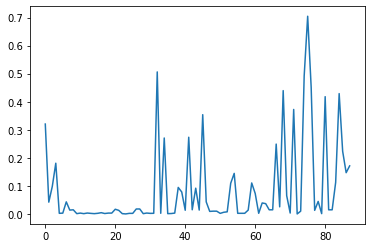

In [ ]:
# Normalized page dimensions
word_to_word_vdist_plot(vword_json)

In [ ]:
data = torch.randn(1, 10)
print(data[0])
test = torch.randn(1, 10)
print('\n')
print(test)

dist = torch.norm(data - test, dim=1, p=None)
knn = dist.topk(1, largest=False)

print('kNN dist: {}, index: {}'.format(knn.values, knn.indices))

tensor([-1.0467, -0.8835, -1.2421,  0.6859,  0.5996, -1.0550, -1.2513,  0.5326,
        -0.3221, -0.1151])


tensor([[ 1.6275, -1.2854, -0.0637,  2.0715,  0.2292, -1.8815,  1.5919, -0.6625,
          1.2741, -0.0819]])
kNN dist: tensor([4.8480]), index: tensor([0])
